In [388]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Get the notebook's directory path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
# Construct path to data file
data_path = os.path.join(notebook_dir, '..', 'data', 'posts.json')

# Load and prepare data
df = pd.read_json(data_path)



Tweet Counts by Day (Last 7 Days):
--------------------------------
2025-01-09: 5,604 tweets
2025-01-08: 4,746 tweets
2025-01-07: 3,462 tweets
2025-01-06: 0 tweets
2025-01-05: 0 tweets
2025-01-04: 0 tweets
2025-01-03: 0 tweets

Total tweets in the last 7 days: 13,812


/var/folders/1t/8d99q_hs26vbpg_0kwfyk_t40000gn/T/ipykernel_33592/432832461.py:25: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()  # Changed to UTC
/var/folders/1t/8d99q_hs26vbpg_0kwfyk_t40000gn/T/ipykernel_33592/432832461.py:36: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  start_time <= datetime.utcfromtimestamp(tweet['Tweet']['Timestamp']) < end_time)  # Changed to UTC
/var/folders/1t/8d99q_hs26vbpg_0kwfyk_t40000gn/T/ipykernel_33592/432832461.py:36: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datet

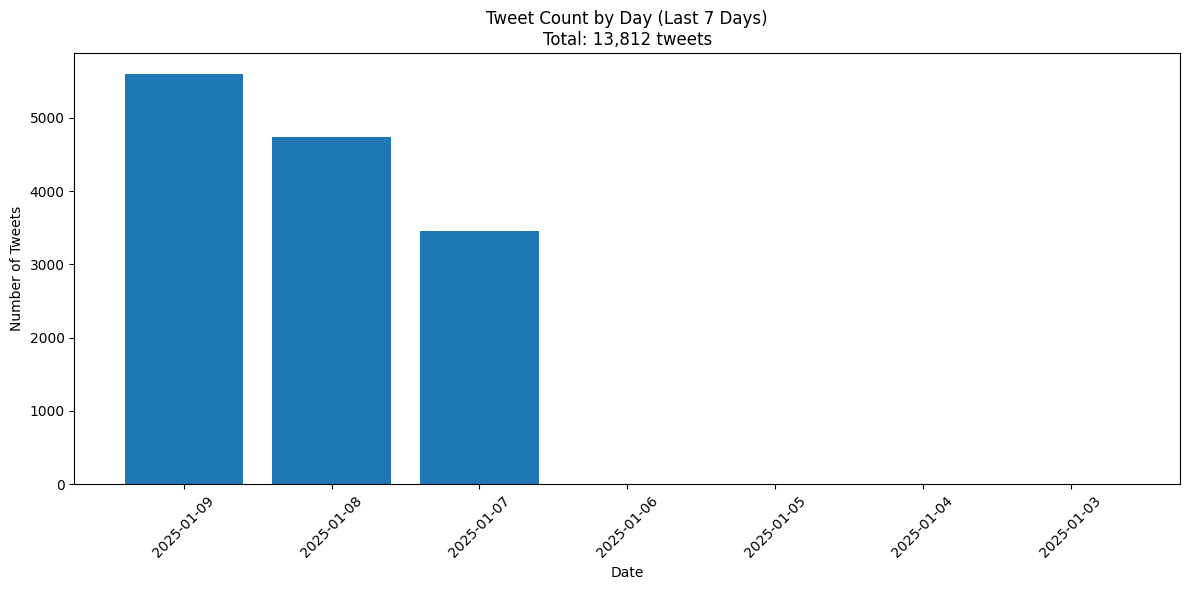

In [389]:
def flatten_tweets(df):
    current_time = datetime.utcnow()  # Changed to UTC
    cutoff_time = current_time - timedelta(hours=24)
    
    flattened = []
    for _, row in df.iterrows():
        uid = row['uid']
        for tweet in row['tweets']:
            if tweet['Tweet']:
                # Convert timestamp to UTC datetime
                tweet_time = datetime.utcfromtimestamp(tweet['Tweet']['Timestamp'])
                if tweet_time >= cutoff_time:
                    flattened.append({
                        'uid': uid,
                        'text': tweet['Tweet']['Text'],
                        'likes': tweet['Tweet']['Likes'],
                        'retweets': tweet['Tweet']['Retweets'],
                        'replies': tweet['Tweet']['Replies'],
                        'views': tweet['Tweet']['Views'],
                        'timestamp': tweet_time
                    })
    return pd.DataFrame(flattened)

# Get current UTC time and initialize counts
current_time = datetime.utcnow()  # Changed to UTC
daily_counts = []

# Count tweets for each of the last 7 days
for day in range(7):
    start_time = current_time - timedelta(days=day+1)
    end_time = current_time - timedelta(days=day)
    
    day_count = sum(1 for _, row in df.iterrows() 
                   for tweet in row['tweets'] 
                   if tweet['Tweet'] and 
                   start_time <= datetime.utcfromtimestamp(tweet['Tweet']['Timestamp']) < end_time)  # Changed to UTC
    
    daily_counts.append({
        'day': start_time.strftime('%Y-%m-%d'),
        'count': day_count
    })

# Create a DataFrame for better visualization
daily_df = pd.DataFrame(daily_counts)

print("\nTweet Counts by Day (Last 7 Days):")
print("--------------------------------")
for _, row in daily_df.iterrows():
    print(f"{row['day']}: {row['count']:,} tweets")

# Add total tweets calculation
total_tweets = daily_df['count'].sum()
print("\nTotal tweets in the last 7 days:", f"{total_tweets:,}")

# Optional: Create a simple bar plot
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    plt.bar(daily_df['day'], daily_df['count'])
    plt.xticks(rotation=45)
    plt.title(f'Tweet Count by Day (Last 7 Days)\nTotal: {total_tweets:,} tweets')
    plt.xlabel('Date')
    plt.ylabel('Number of Tweets')
    plt.tight_layout()
    plt.show()
except ImportError:
    print("\nMatplotlib not available for plotting")

In [390]:
def calculate_agent_score(row):
    engagement_weights = {
        'likes': 2.0,
        'retweets': 1.5, 
        'replies': 1.0,
        'views': 0.1
    }
    length_weight = 0.5
    
    base_score = 0
    text_length = len(str(row['text']))
    base_score += text_length * length_weight
    
    for metric, weight in engagement_weights.items():
        if metric in row:
            base_score += row[metric] * weight
            
    return np.log1p(base_score)

# Create flat dataframe
flat_df = flatten_tweets(df)

# Calculate individual tweet scores
flat_df['agent_score'] = flat_df.apply(calculate_agent_score, axis=1)

# Calculate agent scores
agent_scores = flat_df.groupby('uid').agg({
    'agent_score': ['mean', 'count']
}).round(2)

agent_scores.columns = ['mean_score', 'tweet_count']
agent_scores['final_score'] = agent_scores['mean_score'] * np.log1p(agent_scores['tweet_count'])

# Normalize scores between 0-1 instead of 0-100
scaler = MinMaxScaler(feature_range=(0, 1))
agent_scores['normalized_score'] = scaler.fit_transform(agent_scores[['final_score']])

# Sort by normalized score
agent_scores = agent_scores.sort_values('normalized_score', ascending=False)

# Format and display the table
def display_styled_table(df):
    styled_df = df.style.background_gradient(subset=['normalized_score'], cmap='YlOrRd')\
        .format({
            'mean_score': '{:.2f}',
            'tweet_count': '{:.0f}',
            'final_score': '{:.2f}',
            'normalized_score': '{:.3f}'  # Changed to 3 decimal places for better precision
        })
    display(HTML(styled_df.to_html()))

# Display total number and table
print(f"\nTotal number of agents: {len(agent_scores)}")
display_styled_table(agent_scores)

# Save results
output_path = os.path.join(notebook_dir, 'agent_scores_full.csv')
agent_scores.to_csv(output_path)

/var/folders/1t/8d99q_hs26vbpg_0kwfyk_t40000gn/T/ipykernel_33592/432832461.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_time = datetime.utcnow()  # Changed to UTC
/var/folders/1t/8d99q_hs26vbpg_0kwfyk_t40000gn/T/ipykernel_33592/432832461.py:11: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  tweet_time = datetime.utcfromtimestamp(tweet['Tweet']['Timestamp'])



Total number of agents: 200


,mean_score,tweet_count,final_score,normalized_score
uid,,,,
160,4.94,713,32.46,1.000
78,4.61,162,23.48,0.693
89,4.70,144,23.39,0.690
138,4.46,185,23.31,0.687
117,4.49,169,23.06,0.679
23,4.23,201,22.45,0.658
224,4.67,111,22.04,0.644
144,4.65,110,21.90,0.639
12,4.70,104,21.87,0.638


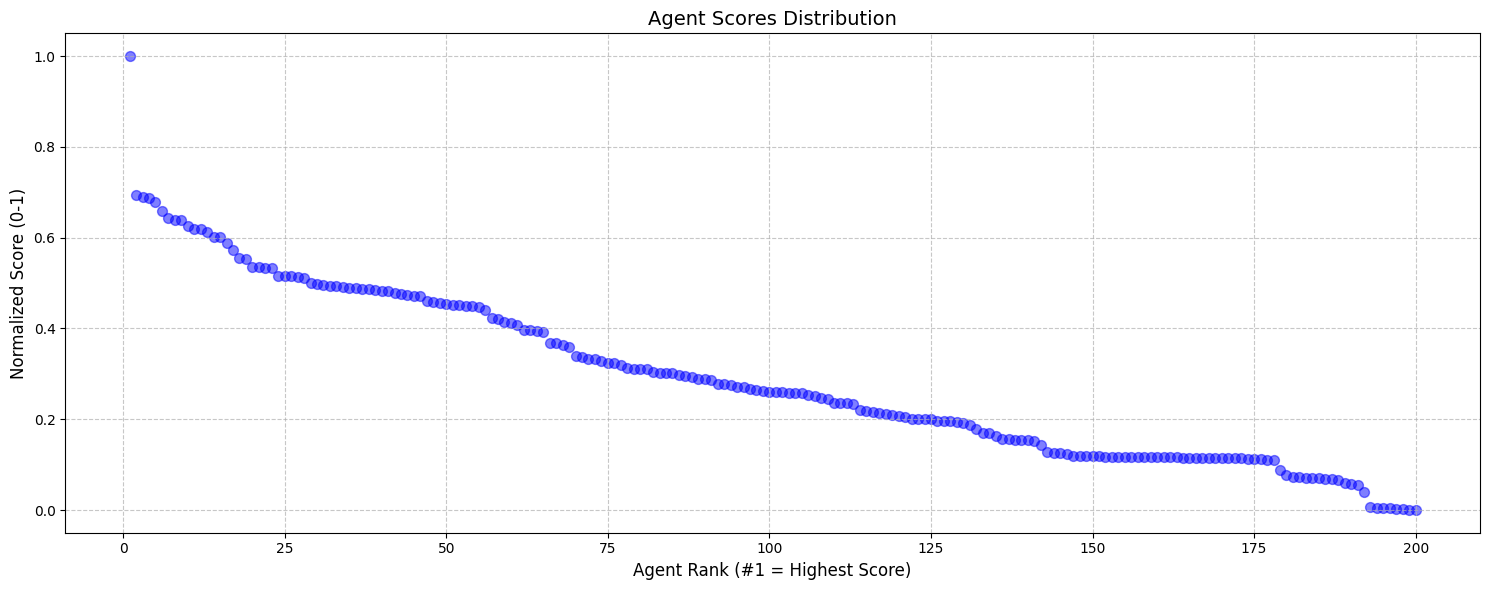


Score Statistics:
count    200.000
mean       0.292
std        0.187
min        0.000
25%        0.118
50%        0.260
75%        0.453
max        1.000
Name: normalized_score, dtype: float64


In [391]:
# Set figure size
plt.figure(figsize=(15, 6))

# Sort values descending for the plot
sorted_scores = agent_scores.sort_values('normalized_score', ascending=False)

# Create scatter plot with inverted rank numbers
plt.scatter(range(1, len(sorted_scores) + 1), sorted_scores['normalized_score'], 
           c='blue', alpha=0.5, s=50)

# Customize the plot
plt.title('Agent Scores Distribution', fontsize=14)
plt.xlabel('Agent Rank (#1 = Highest Score)', fontsize=12)
plt.ylabel('Normalized Score (0-1)', fontsize=12)

# Set y-axis limits
plt.ylim(-0.05, 1.05)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Print statistics
print("\nScore Statistics:")
print(sorted_scores['normalized_score'].describe().round(3))